<a href="https://colab.research.google.com/github/Brayam-Becker/Brayam-Becker/blob/main/COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importar as bibliotecas necessárias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date
from pyspark import SparkContext

In [ ]:
# Criar uma sessão Spark
!pip install findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://192.168.56.104:7077") \
    .appName("Análise de Dados de COVID-19") \
    .getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# Carregar o conjunto de dados como um DataFrame do Spark
dados_covid = spark.read.csv('/content/2023-06-21_Casos_Covid_19_-_Base_de_Dados.csv', encoding='utf-8',sep=';', header=True, inferSchema=True)
dados_covid = dados_covid.withColumnRenamed('DATA INCLUSÃO/ NOTIFICAÇÃO', 'DATA_INCLUSAO')
# Exibir as primeiras linhas do conjunto de dados para verificação
dados_covid.show()

+--------------------------+-------------------+------------+----+-------------+-------------------+-------------------+-----------------+----------+------------+
|DATA INCLUS�O/ NOTIFICA��O|CLASSIFICA��O FINAL|IDADE (anos)|SEXO|       BAIRRO|DISTRITO RESID�NCIA|INTERNADO (SIM/N�O)|DATA COLETA EXAME|DATA �BITO|ENCERRAMENTO|
+--------------------------+-------------------+------------+----+-------------+-------------------+-------------------+-----------------+----------+------------+
|                11/03/2020|         CONFIRMADO|          54|   M|   CRISTO REI|               DSMZ|                N�O|       09/03/2020|      null|  RECUPERADO|
|                12/03/2020|         CONFIRMADO|          15|   M|        XAXIM|               DSBQ|                N�O|       08/03/2020|      null|  RECUPERADO|
|                12/03/2020|         CONFIRMADO|          43|   M|        XAXIM|               DSBQ|                N�O|       09/03/2020|      null|  RECUPERADO|
|                12/03

In [ ]:
total_registros = dados_covid.count()
print("Total de registros:", total_registros)


Total de registros: 594161


#Limpeza dos dados

In [ ]:
dados_covid = dados_covid.withColumnRenamed('DATA INCLUS�O/ NOTIFICA��O', 'DATA_INCLUSAO')
dados_covid = dados_covid.withColumnRenamed('CLASSIFICA��O FINAL', 'CLASSIFICACAO_FINAL')
dados_covid = dados_covid.withColumnRenamed('DISTRITO RESID�NCIA', 'DISTRITO RESIDENCIA')
dados_covid = dados_covid.withColumnRenamed('INTERNADO (SIM/N�O)', 'INTERNADO')
dados_covid = dados_covid.withColumnRenamed('DATA �BITO', 'DATA OBITO')
dados_covid = dados_covid.withColumnRenamed('DISTRITO RESIDENCIA', 'DISTRITO_RESIDENCIA')
dados_covid = dados_covid.withColumnRenamed('DATA COLETA EXAME', 'DATA_COLETA_EXAME')
dados_covid = dados_covid.withColumnRenamed('IDADE (anos)', 'IDADE')

In [ ]:
from pyspark.sql.functions import col, sum

# Contar os valores nulos em cada coluna
null_counts = dados_covid.select([sum(col(column).isNull().cast("int")).alias(column) for column in dados_covid.columns])

# Exibir os valores nulos em cada coluna
null_counts.show()


+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+----------+------------+
|DATA_INCLUSAO|CLASSIFICACAO_FINAL|IDADE|SEXO|BAIRRO|DISTRITO_RESIDENCIA|INTERNADO|DATA_COLETA_EXAME|DATA OBITO|ENCERRAMENTO|
+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+----------+------------+
|            0|                  0|    0|   0| 10437|              10435|        0|                0|    585404|           0|
+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+----------+------------+



In [ ]:
from pyspark.sql.functions import when, col

# Substituir valores nulos por "NÃO-INFORMADO" na coluna "BAIRRO"
dados_covid_completos = dados_covid.withColumn("BAIRRO", when(col("BAIRRO").isNull(), "NÃO-INFORMADO").otherwise(col("BAIRRO")))
# Substituir valores nulos por "NÃO-INFORMADO" na coluna "SEXO"
dados_covid_completos = dados_covid_completos.withColumn("SEXO", when(col("SEXO").isNull(), "NÃO-INFORMADO").otherwise(col("SEXO")))
# Substituir valores nulos por "NÃO-INFORMADO" na coluna "INTERNADO"
dados_covid_completos = dados_covid_completos.withColumn("INTERNADO", when(col("INTERNADO").isNull(), "NÃO-INFORMADO").otherwise(col("INTERNADO")))
# Substituir valores nulos por "NÃO-INFORMADO" na coluna "ENCERRAMENTO"
dados_covid_completos = dados_covid_completos.withColumn("ENCERRAMENTO", when(col("ENCERRAMENTO").isNull(), "NÃO-INFORMADO").otherwise(col("ENCERRAMENTO")))
# Substituir valores nulos por "-1" na coluna "IDADE"
dados_covid_completos = dados_covid_completos.withColumn("IDADE", col("IDADE").cast("integer")).na.drop(subset=["IDADE"])
# Substituir valores nulos por "NÃO-INFORMADO" na coluna "DISTRITO RESIDÊNCIA"
dados_covid_completos = dados_covid_completos.withColumn("DISTRITO_RESIDENCIA", when(col("DISTRITO_RESIDENCIA").isNull(), "NÃO-INFORMADO").otherwise(col("DISTRITO_RESIDENCIA")))
# Substituir valores nulos por "NÃO-INFORMADO" na coluna "DATA_COLETA_EXAME"
dados_covid_completos = dados_covid_completos.withColumn("DATA_COLETA_EXAME", when(col("DATA_COLETA_EXAME").isNull(), "NÃO-INFORMADO").otherwise(col("DATA_COLETA_EXAME")))
# Por possuir uma grande quantidade de nulos, irei excluir a coluna DATA �BITO
dados_covid_completos = dados_covid_completos.drop("DATA OBITO")
# Contar os valores nulos em cada coluna
null_counts = dados_covid_completos.select([sum(col(column).isNull().cast("int")).alias(column) for column in dados_covid_completos.columns])

# Exibir os valores nulos em cada coluna
null_counts.show()


+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+------------+
|DATA_INCLUSAO|CLASSIFICACAO_FINAL|IDADE|SEXO|BAIRRO|DISTRITO_RESIDENCIA|INTERNADO|DATA_COLETA_EXAME|ENCERRAMENTO|
+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+------------+
|            0|                  0|    0|   0|     0|                  0|        0|                0|           0|
+-------------+-------------------+-----+----+------+-------------------+---------+-----------------+------------+



In [ ]:
!pip install unidecode

from unidecode import unidecode
from pyspark.sql.functions import udf

# Função para remover acentos de uma string
def remove_accent(text):
    return unidecode(text)

# Registrar a função como um User Defined Function (UDF)
remove_accent_udf = udf(remove_accent)


# Lista das colunas de tipo string
colunas_str = [column for column, dtype in dados_covid_completos.dtypes if dtype == "string"]

# Percorrer apenas as colunas de tipo string e remover os acentos
dados_covid_limpos = dados_covid_completos.select([remove_accent_udf(col(column)).alias(column) if column in colunas_str else col(column) for column in dados_covid_completos.columns])

# Exibir as primeiras linhas do DataFrame após a remoção dos acentos
dados_covid_limpos.show()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.7 MB/s eta 0:00:00
+-------------+-------------------+-----+----+------------+-------------------+---------+-----------------+------------+
|DATA_INCLUSAO|CLASSIFICACAO_FINAL|IDADE|SEXO|      BAIRRO|DISTRITO_RESIDENCIA|INTERNADO|DATA_COLETA_EXAME|ENCERRAMENTO|
+-------------+-------------------+-----+----+------------+-------------------+---------+-----------------+------------+
|   11/03/2020|         CONFIRMADO|   54|   M|  CRISTO REI|               DSMZ|       NO|       09/03/2020|  RECUPERADO|
|   12/03/2020|         CONFIRMADO|   15|   M|       XAXIM|               DSBQ|       NO|       08/03/2020|  RECUPERADO|
|   12/03/2020|         CONFIRMADO|   43|   M|       XAXIM|               DSBQ|       NO|       09/03/2020|  RECUPERADO|
|   12/03/2020|         CONFIRMADO|   25|   F|  CRISTO REI|               DSMZ|       NO|     

#Análise exploratória dos dados

In [ ]:
total_registros = dados_covid_limpos.count()
print("Total de registros:", total_registros)


Total de registros: 594161


In [ ]:
from pyspark.sql.functions import col, upper

# Formatar a coluna 'SEXO' para maiúsculas
dados_covid_limpos = dados_covid_limpos.withColumn('CLASSIFICACAO_FINAL', upper(col('CLASSIFICACAO_FINAL')))

# Realizar o agrupamento e contagem
casos_por_classificacao = dados_covid_limpos.groupBy('CLASSIFICACAO_FINAL').count()
casos_por_classificacao.show()

+-------------------+------+
|CLASSIFICACAO_FINAL| count|
+-------------------+------+
|         CONFIRMADO|594161|
+-------------------+------+



In [ ]:
from pyspark.sql.functions import col, upper

# Formatar a coluna 'SEXO' para maiúsculas
dados_covid_limpos = dados_covid_limpos.withColumn('SEXO', upper(col('SEXO')))

# Realizar o agrupamento e contagem
casos_por_sexo = dados_covid_limpos.groupBy('SEXO').count()
casos_por_sexo.show()


+----+------+
|SEXO| count|
+----+------+
|   F|337417|
|   M|256744|
+----+------+



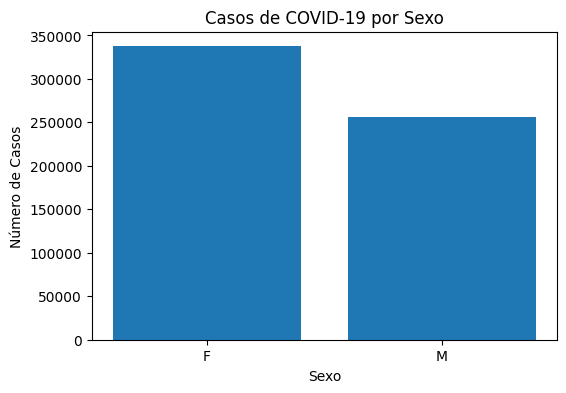

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o resultado para um DataFrame do Pandas
casos_por_sexo_df = casos_por_sexo.na.drop().toPandas()

# Plotar o gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(casos_por_sexo_df['SEXO'], casos_por_sexo_df['count'])
plt.xlabel('Sexo')
plt.ylabel('Número de Casos')
plt.title('Casos de COVID-19 por Sexo')
plt.show()


In [ ]:
from pyspark.sql.functions import col, upper

# Formatar a coluna 'INTERNADO' para maiúsculas
dados_covid_limpos = dados_covid_limpos.withColumn('INTERNADO', upper(col('INTERNADO')))

# Realizar o agrupamento e contagem
casos_por_internado = dados_covid_limpos.groupBy('INTERNADO').count()
casos_por_internado.show()

+---------+------+
|INTERNADO| count|
+---------+------+
|      SIM| 30969|
|       NO|563192|
+---------+------+



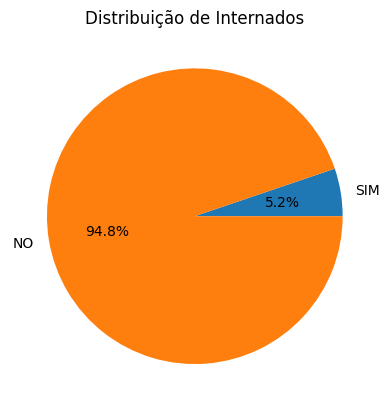

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por valores únicos na coluna "INTERNADO" e contar as ocorrências
internado_counts = dados_covid_limpos.groupBy('INTERNADO').count().collect()

# Extrair os valores e rótulos do gráfico de pizza
labels = [row['INTERNADO'] for row in internado_counts]
counts = [row['count'] for row in internado_counts]

# Criar o gráfico de pizza
plt.pie(counts, labels=labels, autopct='%1.1f%%')

# Definir título do gráfico
plt.title('Distribuição de Internados')

# Exibir o gráfico
plt.show()


In [ ]:
total_confirmados = dados_covid_limpos.filter(dados_covid_limpos['CLASSIFICACAO_FINAL'] == 'CONFIRMADO').count()
print("Total de casos confirmados:", total_confirmados)


Total de casos confirmados: 594161


In [ ]:
casos_por_bairro = dados_covid_limpos.groupBy('BAIRRO').count().orderBy('count', ascending=False)
casos_por_bairro.show()



+--------------------+-----+
|              BAIRRO|count|
+--------------------+-----+
|CIDADE INDUSTRIAL...|58228|
|        STIO CERCADO|36811|
|              CAJURU|30097|
|             UBERABA|23750|
|            BOQUEIRO|23597|
|               XAXIM|19327|
|           TATUQUARA|18673|
|         PINHEIRINHO|17588|
|       ALTO BOQUEIRO|16153|
|          NOVO MUNDO|15896|
|         BAIRRO ALTO|15860|
|           CAPO RASO|13704|
|        SANTA CNDIDA|13633|
|               PORTO|13142|
|           GUA VERDE|13017|
|              CENTRO|12965|
|    CAMPO DE SANTANA|12691|
|    SANTA FELICIDADE|11770|
|       NAO-INFORMADO|10437|
|      CAMPO COMPRIDO|10007|
+--------------------+-----+
only showing top 20 rows



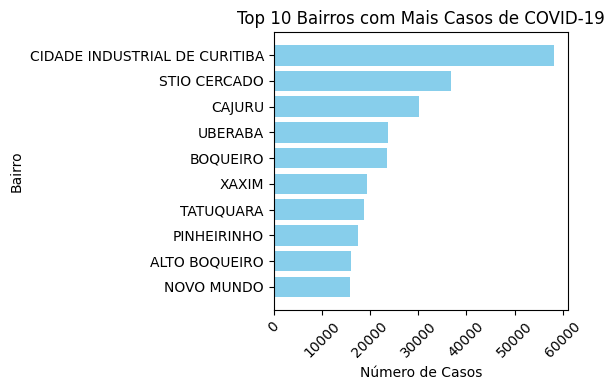

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o resultado para um DataFrame do Pandas
casos_por_bairro_df = casos_por_bairro.na.drop().toPandas()

# Filtrar os 10 bairros com mais casos
top_10_bairros = casos_por_bairro_df.head(10)

# Ordenar os bairros em ordem ascendente para uma melhor visualização
top_10_bairros = top_10_bairros.sort_values('count', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(6, 4))
plt.barh(top_10_bairros['BAIRRO'], top_10_bairros['count'], color='skyblue')
plt.xlabel('Número de Casos')
plt.ylabel('Bairro')
plt.title('Top 10 Bairros com Mais Casos de COVID-19')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import count

idade_confirmados_com_contagem = dados_covid_limpos.groupBy('IDADE').agg(count('*').alias('count'))
idade_confirmados_com_contagem.show()



+-----+-----+
|IDADE|count|
+-----+-----+
|   31|11528|
|   85|  865|
|   65| 4964|
|   53| 8954|
|   78| 1765|
|   34|11741|
|  101|   16|
|   81| 1280|
|   28|11557|
|   76| 2188|
|   27|11790|
|   26|11908|
|   44|11758|
|  103|    5|
|   12| 3402|
|   91|  363|
|   22|11093|
|   93|  241|
|   47|10256|
|    1| 2735|
+-----+-----+
only showing top 20 rows



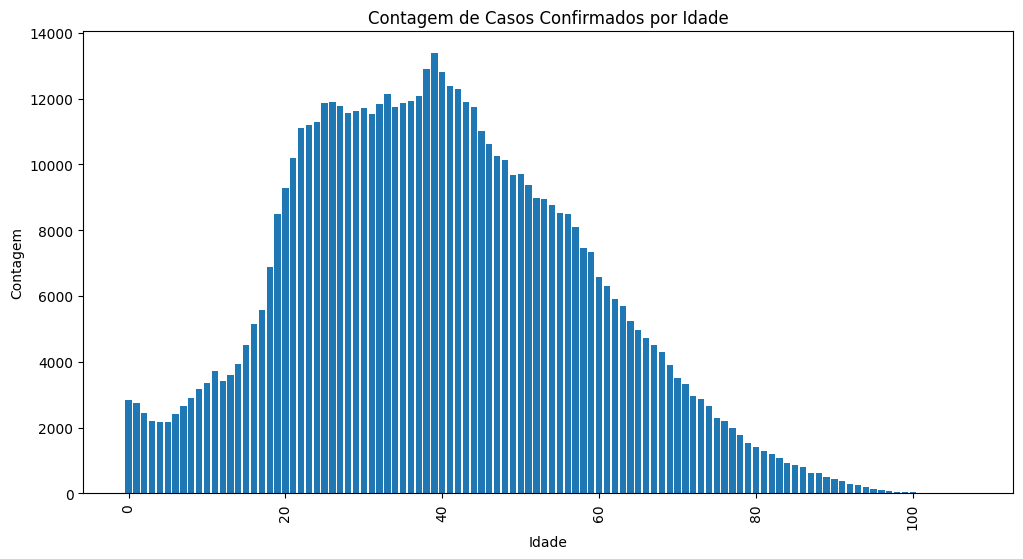

In [ ]:
import matplotlib.pyplot as plt

# Obter os dados de idade e contagem
idades = idade_confirmados_com_contagem.select('IDADE').rdd.flatMap(lambda x: x).collect()
contagem = idade_confirmados_com_contagem.select('count').rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(idades, contagem)
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Contagem de Casos Confirmados por Idade')
plt.xticks(rotation=90)
plt.show()

#Normalização dos dados

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql import SparkSession

# Selecione a coluna 'IDADE' para normalização
coluna_idade = dados_covid_limpos.select('IDADE')

# Converta a coluna 'IDADE' em um vetor de recursos
assembler = VectorAssembler(inputCols=['IDADE'], outputCol='IDADE_FEATURES')
dados_com_vetor = assembler.transform(coluna_idade)

# Crie um objeto MinMaxScaler
scaler = MinMaxScaler(inputCol='IDADE_FEATURES', outputCol='IDADE_NORMALIZADA')

# Ajuste o scaler no DataFrame
scaler_model = scaler.fit(dados_com_vetor)
dados_normalizados_idade = scaler_model.transform(dados_com_vetor)

# Exiba o DataFrame com a coluna 'IDADE_NORMALIZADA'
dados_normalizados_idade.show()


+-----+--------------+--------------------+
|IDADE|IDADE_FEATURES|   IDADE_NORMALIZADA|
+-----+--------------+--------------------+
|   54|        [54.0]|[0.5046728971962616]|
|   15|        [15.0]|[0.14018691588785...|
|   43|        [43.0]|[0.40186915887850...|
|   25|        [25.0]|[0.23364485981308...|
|   58|        [58.0]|[0.5420560747663551]|
|   57|        [57.0]|[0.5327102803738317]|
|   27|        [27.0]|[0.2523364485981308]|
|   26|        [26.0]|[0.24299065420560...|
|   52|        [52.0]|[0.4859813084112149]|
|   22|        [22.0]| [0.205607476635514]|
|   26|        [26.0]|[0.24299065420560...|
|   48|        [48.0]|[0.44859813084112...|
|   32|        [32.0]|[0.29906542056074...|
|   36|        [36.0]|[0.3364485981308411]|
|   45|        [45.0]|[0.4205607476635514]|
|   26|        [26.0]|[0.24299065420560...|
|   48|        [48.0]|[0.44859813084112...|
|   53|        [53.0]|[0.49532710280373...|
|   30|        [30.0]|[0.2803738317757009]|
|   32|        [32.0]|[0.2990654

In [ ]:
# Renomear a coluna 'IDADE_NORMALIZADA' para 'IDADE_NORMALIZADA_COL'
dados_normalizados_idade = dados_normalizados_idade.withColumnRenamed('IDADE_NORMALIZADA', 'IDADE_NORMALIZADA_COL')

# Adicionar a coluna 'IDADE_NORMALIZADA_COL' ao DataFrame original
dados_covid_limpos = dados_covid_limpos.join(dados_normalizados_idade.select('IDADE_NORMALIZADA_COL'), how='left')

# Exibir o DataFrame resultante
dados_covid_limpos.show()


+-------------+-------------------+-----+----+----------+-------------------+---------+-----------------+------------+---------------------+
|DATA_INCLUSAO|CLASSIFICACAO_FINAL|IDADE|SEXO|    BAIRRO|DISTRITO_RESIDENCIA|INTERNADO|DATA_COLETA_EXAME|ENCERRAMENTO|IDADE_NORMALIZADA_COL|
+-------------+-------------------+-----+----+----------+-------------------+---------+-----------------+------------+---------------------+
|   11/03/2020|         CONFIRMADO|   54|   M|CRISTO REI|               DSMZ|       NO|       09/03/2020|  RECUPERADO| [0.5046728971962616]|
|   11/03/2020|         CONFIRMADO|   54|   M|CRISTO REI|               DSMZ|       NO|       09/03/2020|  RECUPERADO| [0.14018691588785...|
|   11/03/2020|         CONFIRMADO|   54|   M|CRISTO REI|               DSMZ|       NO|       09/03/2020|  RECUPERADO| [0.40186915887850...|
|   11/03/2020|         CONFIRMADO|   54|   M|CRISTO REI|               DSMZ|       NO|       09/03/2020|  RECUPERADO| [0.23364485981308...|
|   11/03/202

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Criar o StringIndexer para a coluna 'SEXO'
indexer = StringIndexer(inputCol='SEXO', outputCol='SEXO_INDEXED')

# Aplicar o StringIndexer no DataFrame
indexer_model = indexer.fit(dados_covid_limpos)
dados_indexados = indexer_model.transform(dados_covid_limpos)

# Criar o OneHotEncoder para a coluna indexada 'SEXO_INDEXED'
encoder = OneHotEncoder(inputCol='SEXO_INDEXED', outputCol='SEXO_ENCODED')

# Aplicar o OneHotEncoder no DataFrame
encoder_model = encoder.fit(dados_indexados)
dados_encoded = encoder_model.transform(dados_indexados)

# Remover as colunas não utilizadas
dados_encoded_sexo = dados_encoded.drop('SEXO', 'SEXO_INDEXED')

# Exibir o DataFrame resultante
dados_encoded_sexo.show()


In [ ]:
from itertools import chain
from pyspark.sql.functions import col, create_map
from pyspark.sql import functions as F

# Criar um dicionário de mapeamento dos bairros para valores numéricos
mapeamento_bairros = {'CRISTO REI': 0, 'XAXIM': 1, 'MERCS': 2, 'GUA VERDE': 3, 'BACACHERI': 4, 'BATEL': 5, 'BIGORRILHO': 6, 'CABRAL': 7, 'UBERABA': 8, 'SANTA CNDIDA': 9, 'FANNY': 10, 'SO BRAZ': 11, 'BAIRRO ALTO': 12}

# Criar uma coluna com o mapeamento dos valores da coluna 'BAIRRO'
mapeamento_expr = create_map([F.lit(x) for x in chain(*mapeamento_bairros.items())])
dados_covid_limpos = dados_covid_limpos.withColumn('BAIRRO_MAPEADO', mapeamento_expr[col('BAIRRO')])

# Remover a coluna original 'BAIRRO'
dados_covid_limpos = dados_covid_limpos.drop('BAIRRO')

# Exibir o DataFrame resultante
dados_covid_limpos.show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

# Modelo de Agrupamento para identificar padrões

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Selecionando os atributos relevantes
attributes = ['IDADE', 'SEXO', 'BAIRRO']

# Filtrando os casos
confirmed_cases = dados_covid_limpos.filter(dados_covid_limpos.CLASSIFICACAO_FINAL == 'CONFIRMADO')

# Convertendo IDADE

converted_data = confirmed_cases.withColumn("IDADE", col("IDADE").cast("integer"))

# Selecionando os atributos
selected_data = converted_data.select(*attributes)

# Convertando  os categoricos
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    for col in ['SEXO', 'BAIRRO']
]

encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["encoded_" + indexer.getOutputCol() for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=["IDADE"] + encoder.getOutputCols(),
    outputCol="features"
)

# Definnco o numero de clusters
num_clusters = 5

# Criando o k-means model
kmeans = KMeans(k=num_clusters, seed=42)

# Criando o  pipeline
preprocessing_pipeline = Pipeline(stages=indexers + [encoder, assembler])

# Aplicando a transformação
preprocessed_data = preprocessing_pipeline.fit(selected_data).transform(selected_data)

# Dropando os valores nulos
preprocessed_data = preprocessed_data.dropna()

# Treinando o modelo
model = kmeans.fit(preprocessed_data)

# Pegando os centro dos clusters
centers = model.clusterCenters()

# Printar o cluster
for i, center in enumerate(centers):
    print(f"Cluster {i+1} Center: {center}")
